In [1]:
import numpy as np
import extq
import matplotlib.pyplot as plt
from matplotlib import ticker
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics
import ivac
import seaborn as sns

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import kde

In [3]:
from util import delay_embed, lift_function

In [4]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load data and CVs 

In [5]:
livac_trajs = np.load(
    "../../data/sb_ind100_TICA/livac_trajs_anton.npy", allow_pickle=True
)
ri_trajs = np.load("../../data/raw_feat/ri126_dist_anton.npz.npy", allow_pickle=True)
cv_trajs = np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)

In [6]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [7]:
remove = [
    1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
]

In [8]:
data_trajs = np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True)

In [9]:
print(len(livac_trajs), len(ri_trajs), len(data_trajs), len(cv_trajs))

livac_arr = np.concatenate(livac_trajs)
ri_arr = np.concatenate(ri_trajs)
data_arr = np.concatenate(data_trajs)
cv_arr = np.concatenate(cv_trajs)
print(livac_arr.shape, ri_arr.shape, data_arr.shape, cv_arr.shape)

237 237 237 237
(3000000, 5) (3000000, 5) (3000000, 60) (3000000, 2)


In [10]:
ivac_trajs = np.load("../../data/feat2_anton_ivac.npy", allow_pickle=True)
ivac_arr = np.concatenate(ivac_trajs)
print(len(ivac_trajs), ivac_trajs[0].shape)
print(ivac_arr.shape)

237 (10000, 10)
(3000000, 10)


# Plot autocorrelation of salt bridge features

In [11]:
from ivac import utils

In [11]:
sb_ids = [36, 42, 47, 48, 53, 59]
sb_trajs = [traj[:, sb_ids] for traj in data_trajs]

In [12]:
from scipy.signal import correlate

In [45]:
l = len(sb_trajs[0])
ac = np.zeros_like(sb_trajs[0])
for traj in sb_trajs:
    ac += correlate(traj[:l], traj[:l], mode="same") / l

In [46]:
ac.shape

(10000, 6)

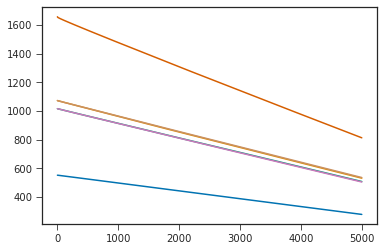

In [54]:
for sb in ac.T:
    plt.plot(sb[l // 2 :])

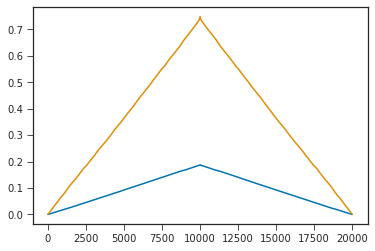

In [16]:
ac = correlate(data_trajs[0][:, 36], data_trajs[0][:, 36])
ac2 = correlate(data_trajs[0][:, 42], data_trajs[0][:, 42])
plt.plot(ac / 10000)
plt.plot(ac2 / 10000)

In [17]:
ac.shape

(19999,)

In [30]:
N = len(data_trajs[0])
ac = np.zeros((6, 19999))
for traj in data_trajs:
    for i, index in enumerate(sb_ids):
        ac[i] += correlate(traj[:N, index], traj[:N, index]) / N

Text(0, 0.5, 'Autocorrelation')

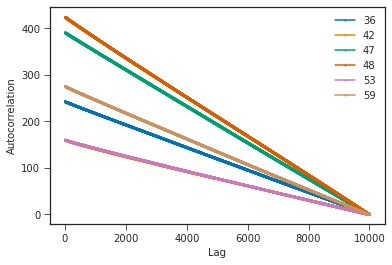

In [53]:
for i, a in enumerate(ac):
    plt.plot(a[N:], ".-", label=f"{sb_ids[i]}", ms=2)
plt.legend(loc="upper right")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
# plt.yscale('log')

In [32]:
from scipy.optimize import curve_fit

(0.0, 400.0)

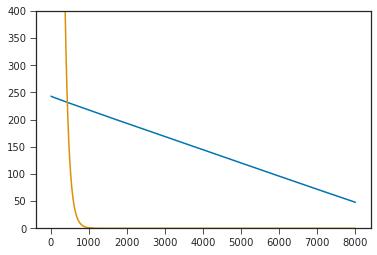

In [61]:
# exponential fitting
x = np.arange(8000)
((a, b), _) = curve_fit(
    lambda t, a, b: a * np.exp(b * t), ac[0, 10000:18000], x, p0=(200, -0.001)
)
plt.plot(ac[0, 10000:18000])
plt.plot(x, a * np.exp(b * x))
plt.ylim([0, 400])

In [60]:
curve_fit(lambda t, a, b: a * np.exp(b * t), ac[0, 10000:18000], x, p0=(100, -0.001))

(array([ 1.41484839e+04, -9.61271230e-03]),
 array([[ 2.15947678e+03, -1.34834811e-03],
        [-1.34834811e-03,  1.00556376e-09]]))

In [25]:
N = len(data_trajs[179])
ac = np.zeros((6, 199999))
for traj in data_trajs[179:186]:
    for i, index in enumerate(sb_ids):
        ac[i] += correlate(traj[:N, index], traj[:N, index]) / N

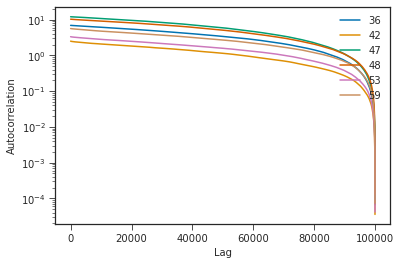

In [29]:
for i, a in enumerate(ac):
    plt.plot(a[N:], label=f"{sb_ids[i]}")
plt.legend(loc="upper right")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.yscale("log")

In [27]:
ac[0, -1]

6.711039692163467e-05

In [28]:
ac[1, -1]

3.583359926939011e-05

# Plot against delay embedded coordinates 

In [56]:
cv_embed = delay_embed(cv_trajs, 1, lag=10)
embed_cv_arr = np.concatenate(cv_embed)
print(embed_cv_arr.shape)

(2997630, 4)


In [58]:
lifted_cvs = np.concatenate(lift_function(cv_trajs, 1, lag=10))
lifted_cvs.shape

(2997630, 2)

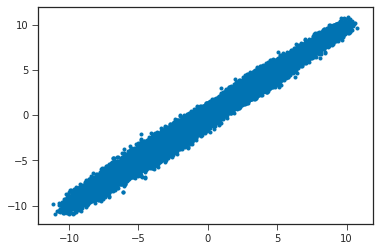

In [60]:
s = 10
plt.plot(lifted_cvs[::s, 0], embed_cv_arr[::s, 2], ".")

## dist/rot 

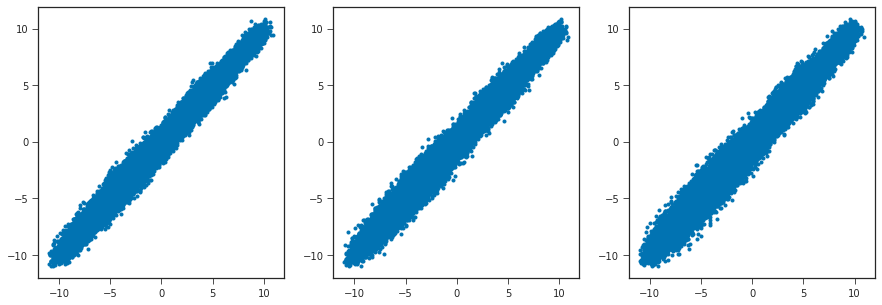

In [71]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
for delay, ax in zip((10, 20, 40), axs):
    lagged_cvs = np.concatenate([traj[delay:] for traj in cv_trajs])
    unlagged_cvs = np.concatenate([traj[:-delay] for traj in cv_trajs])
    ax.plot(unlagged_cvs[::s, 0], lagged_cvs[::s, 0], ".")

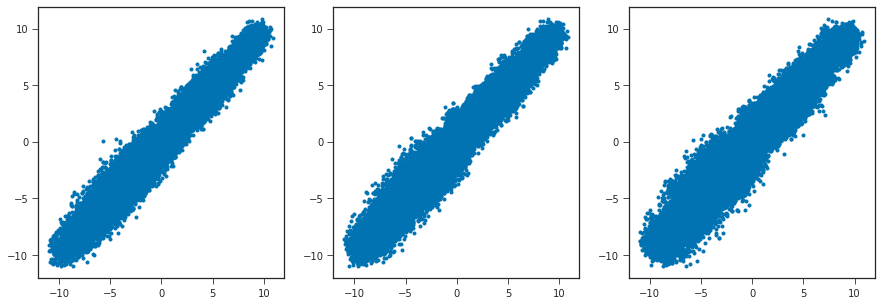

In [72]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
for delay, ax in zip((100, 200, 400), axs):
    lagged_cvs = np.concatenate([traj[delay:] for traj in cv_trajs])
    unlagged_cvs = np.concatenate([traj[:-delay] for traj in cv_trajs])
    ax.plot(unlagged_cvs[::s, 0], lagged_cvs[::s, 0], ".")

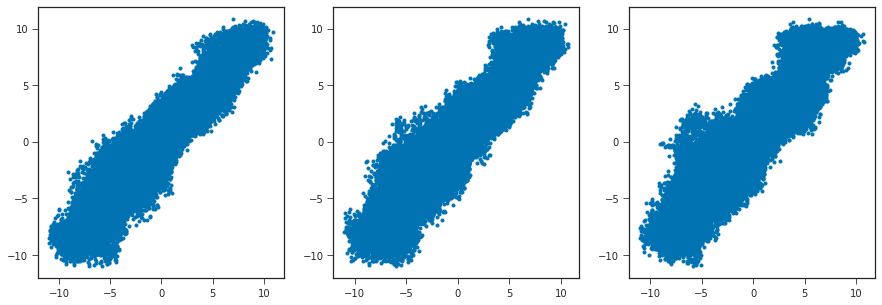

In [91]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
for delay, ax in zip((1000, 2000, 4000), axs):
    lagged_cvs = np.concatenate([traj[delay:] for traj in cv_trajs])
    unlagged_cvs = np.concatenate([traj[:-delay] for traj in cv_trajs])
    ax.plot(unlagged_cvs[::s, 0], lagged_cvs[::s, 0], ".")

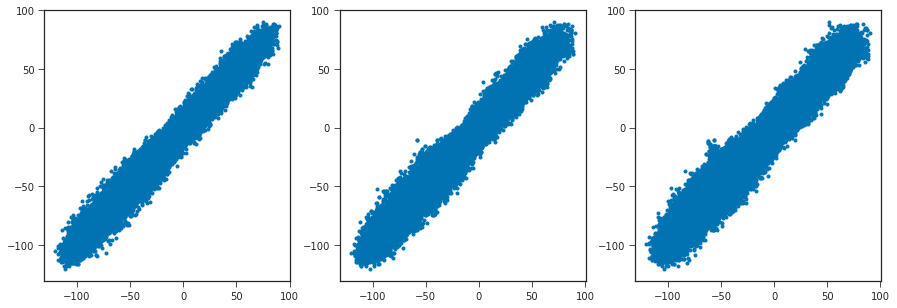

In [73]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
for delay, ax in zip((100, 200, 400), axs):
    lagged_cvs = np.concatenate([traj[delay:] for traj in cv_trajs])
    unlagged_cvs = np.concatenate([traj[:-delay] for traj in cv_trajs])
    ax.plot(unlagged_cvs[::s, 1], lagged_cvs[::s, 1], ".")

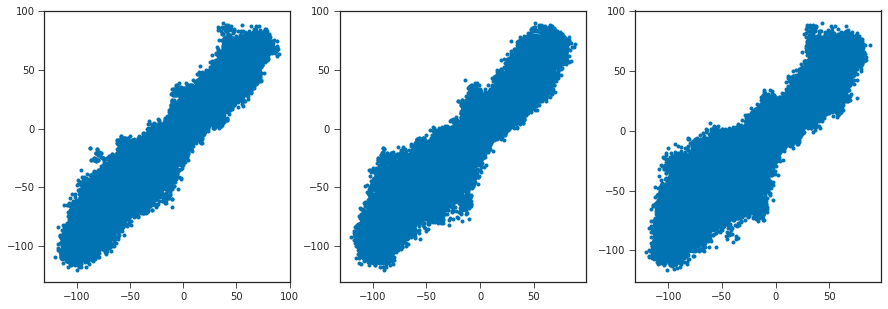

In [92]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
for delay, ax in zip((1000, 2000, 4000), axs):
    lagged_cvs = np.concatenate([traj[delay:] for traj in cv_trajs])
    unlagged_cvs = np.concatenate([traj[:-delay] for traj in cv_trajs])
    ax.plot(unlagged_cvs[::s, 1], lagged_cvs[::s, 1], ".")

## salt bridges 

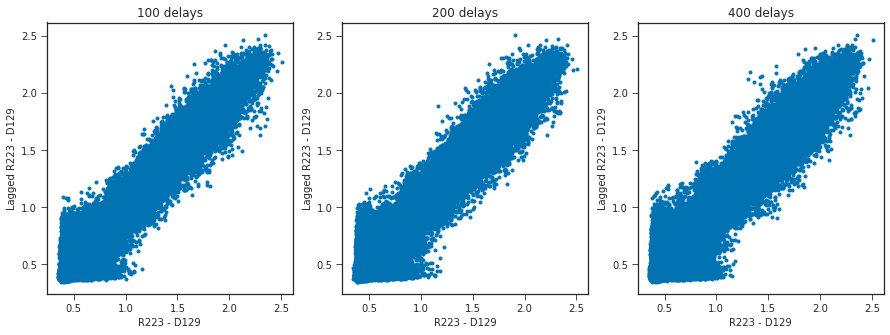

In [83]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
for delay, ax in zip((100, 200, 400), axs):
    lagged_cvs = np.concatenate([traj[delay:] for traj in sb_trajs])
    unlagged_cvs = np.concatenate([traj[:-delay] for traj in sb_trajs])
    ax.plot(unlagged_cvs[::s, 0], lagged_cvs[::s, 0], ".")
    ax.set(
        xlabel=f"{sb_labels[sb_ids[0] - 30]}",
        ylabel=f"Lagged {sb_labels[sb_ids[0] - 30]}",
        title=f"{delay} delays",
    )

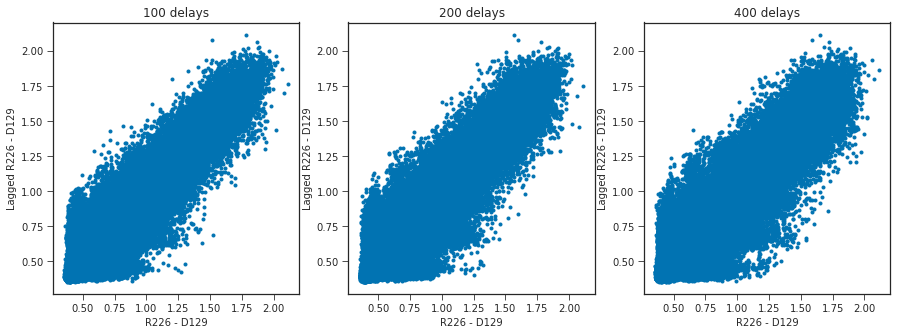

In [84]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
for delay, ax in zip((100, 200, 400), axs):
    lagged_cvs = np.concatenate([traj[delay:] for traj in sb_trajs])
    unlagged_cvs = np.concatenate([traj[:-delay] for traj in sb_trajs])
    ax.plot(unlagged_cvs[::s, 1], lagged_cvs[::s, 1], ".")
    ax.set(
        xlabel=f"{sb_labels[sb_ids[1] - 30]}",
        ylabel=f"Lagged {sb_labels[sb_ids[1] - 30]}",
        title=f"{delay} delays",
    )

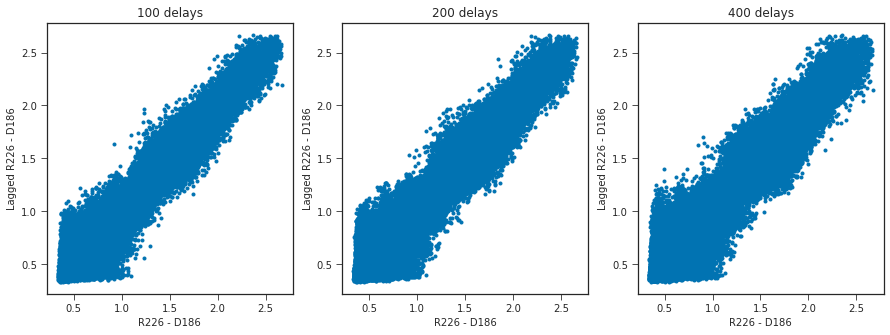

In [85]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
for delay, ax in zip((100, 200, 400), axs):
    lagged_cvs = np.concatenate([traj[delay:] for traj in sb_trajs])
    unlagged_cvs = np.concatenate([traj[:-delay] for traj in sb_trajs])
    ax.plot(unlagged_cvs[::s, 2], lagged_cvs[::s, 2], ".")
    ax.set(
        xlabel=f"{sb_labels[sb_ids[2] - 30]}",
        ylabel=f"Lagged {sb_labels[sb_ids[2] - 30]}",
        title=f"{delay} delays",
    )

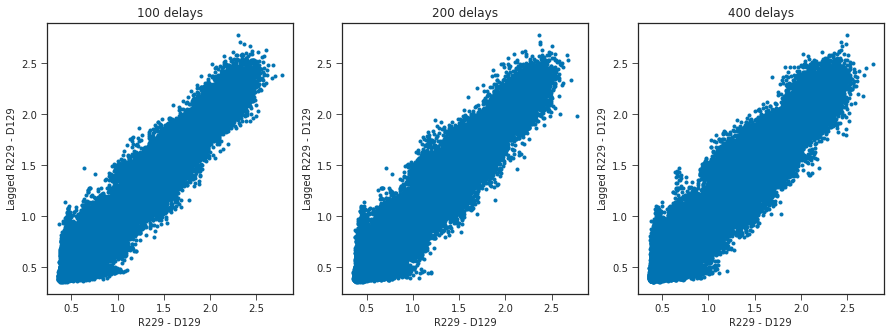

In [86]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
for delay, ax in zip((100, 200, 400), axs):
    lagged_cvs = np.concatenate([traj[delay:] for traj in sb_trajs])
    unlagged_cvs = np.concatenate([traj[:-delay] for traj in sb_trajs])
    ax.plot(unlagged_cvs[::s, 3], lagged_cvs[::s, 3], ".")
    ax.set(
        xlabel=f"{sb_labels[sb_ids[3] - 30]}",
        ylabel=f"Lagged {sb_labels[sb_ids[3] - 30]}",
        title=f"{delay} delays",
    )

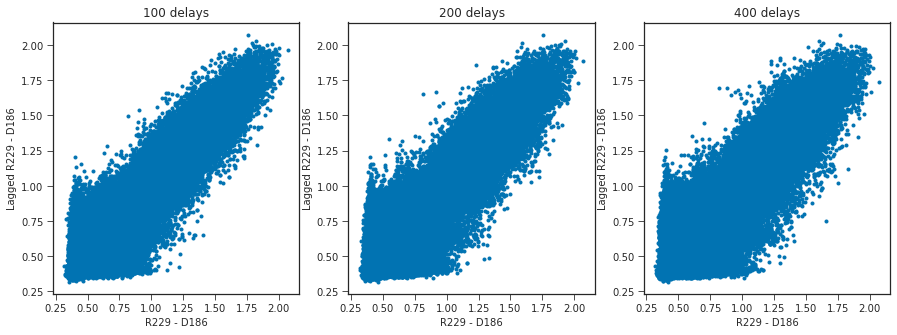

In [87]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
for delay, ax in zip((100, 200, 400), axs):
    lagged_cvs = np.concatenate([traj[delay:] for traj in sb_trajs])
    unlagged_cvs = np.concatenate([traj[:-delay] for traj in sb_trajs])
    ax.plot(unlagged_cvs[::s, 4], lagged_cvs[::s, 4], ".")
    ax.set(
        xlabel=f"{sb_labels[sb_ids[4] - 30]}",
        ylabel=f"Lagged {sb_labels[sb_ids[4] - 30]}",
        title=f"{delay} delays",
    )

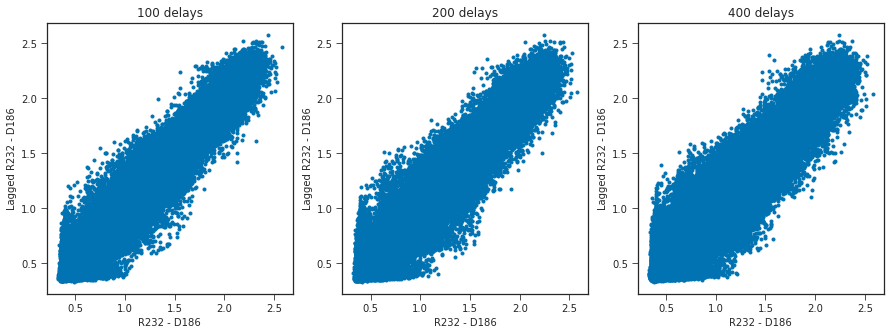

In [88]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
for delay, ax in zip((100, 200, 400), axs):
    lagged_cvs = np.concatenate([traj[delay:] for traj in sb_trajs])
    unlagged_cvs = np.concatenate([traj[:-delay] for traj in sb_trajs])
    ax.plot(unlagged_cvs[::s, 5], lagged_cvs[::s, 5], ".")
    ax.set(
        xlabel=f"{sb_labels[sb_ids[5] - 30]}",
        ylabel=f"Lagged {sb_labels[sb_ids[5] - 30]}",
        title=f"{delay} delays",
    )

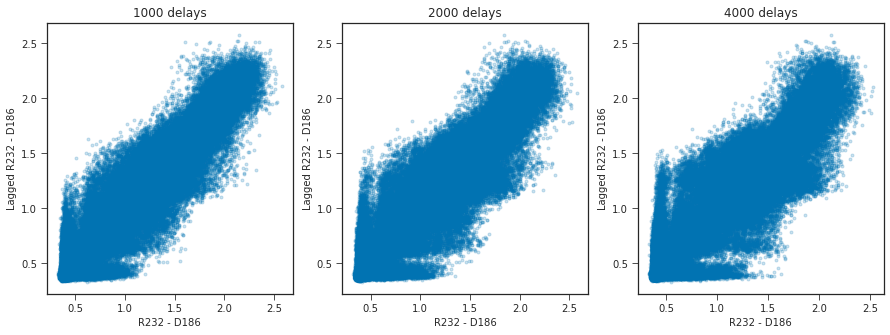

In [90]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
for delay, ax in zip((1000, 2000, 4000), axs):
    lagged_cvs = np.concatenate([traj[delay:] for traj in sb_trajs])
    unlagged_cvs = np.concatenate([traj[:-delay] for traj in sb_trajs])
    ax.plot(unlagged_cvs[::s, 5], lagged_cvs[::s, 5], ".", alpha=0.2)
    ax.set(
        xlabel=f"{sb_labels[sb_ids[5] - 30]}",
        ylabel=f"Lagged {sb_labels[sb_ids[5] - 30]}",
        title=f"{delay} delays",
    )

Interestingly, the most "wide" plots (fastest decorrelating) are R226-D129 and R229-D186 apparently.

Also the salt bridges, as would be expected, decorrelate faster than the distance/rotation CVs, due to our "hysteresis"